### General idea
1. Clean dataset => dfClean
2. Vectorize words => to probability density
3. Perform logistic regression on vectorized words 
    of scales of reviews 0 (0,.1),1 (.2,.3) ,2 (.4,.5),3 (.6,.7) ,4 (.8,.9, 1) reviews

In [1]:
# Read data set and stop words
import pandas as pd
import re 
import nltk
import numpy as np
import time
from sklearn.metrics import roc_curve, auc
nltk.download('stopwords')
df = pd.read_csv (r'/content/AppReview.csv')
len(df.index)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


26021

In [2]:
# Corpus of stop words
from nltk.corpus import stopwords

In [3]:
# processes a review and returns a list of words
def review_to_words(review, string = True, remove_stopwords=True):
    # Remove HTML
    #review_text = BeautifulSoup(review).get_text()
    review_text=review
    # Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # Convert words to lower case and split them
    words = review_text.lower().split()
    # Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    if string:
        return " ".join(words)
    else:
        return words

In [4]:
#Clean up text
#Remove non-ascii text
#Remove all rows missing reviewerName
def fixString(x):
    return x.encode('ascii',errors='ignore')

# df[["reviewText"]]=df[["reviewText"]].apply(lambda x: str(x["reviewText"]).encode('ascii',errors='ignore').decode(), axis=1)
# df[["reviewerName"]]=df[["reviewerName"]].apply(lambda x: str(x["reviewerName"]).encode('ascii',errors='ignore').decode(), axis=1)
df[["reviewText"]]=df[["reviewText"]].apply(lambda x: review_to_words(x["reviewText"]), axis=1)
df[["reviewerName"]]=df[["reviewerName"]].apply(lambda x: str(x["reviewerName"]).encode('ascii',errors='ignore').decode(), axis=1)

dfCleaned=df[df['reviewText'].str.strip().astype(bool)]
dfCleaned=dfCleaned[df['reviewerName'].str.strip().astype(bool)]

#
dfCleaned

,appID,reviewerName,reviewText,reviewerRating,reviewDate,textAnalytics
0,3,Eric Hansen,love well worth money full version came ad blo...,1.0,2017/07/07 00:00:00,NaN
1,3,Jacob N.,awful bug allow use space bar want type search...,0.4,2017/08/29 00:00:00,NaN
2,3,Higgins Family,would stars except bugs example incognito tab ...,0.8,2017/10/02 00:00:00,NaN
3,3,Rajko Dikmann,worked perfect weeks ago browsing experience s...,0.4,2017/09/28 00:00:00,NaN
4,3,Sergei Garcia,hands best browser play store even flagship de...,1.0,2017/07/09 00:00:00,NaN
...,...,...,...,...,...,...
26016,1656,A Google User,getting old great keeps thinking age good thin...,1.0,2012/12/03 00:00:00,NaN
26017,1656,A Google User,fics hopelessly broken full review,0.4,2012/11/28 00:00:00,NaN
26018,1656,A Google User,good job good job good chess problem full review,1.0,2012/11/11 00:00:00,NaN
26019,1656,dhananjay naik,super good game full review,1.0,2012/12/05 00:00:00,NaN


In [5]:
dfCleaned[['reviewText']]

,reviewText
0,love well worth money full version came ad blo...
1,awful bug allow use space bar want type search...
2,would stars except bugs example incognito tab ...
3,worked perfect weeks ago browsing experience s...
4,hands best browser play store even flagship de...
...,...
26016,getting old great keeps thinking age good thin...
26017,fics hopelessly broken full review
26018,good job good job good chess problem full review
26019,super good game full review


## Vectorize words
### This is based on 
https://towardsdatascience.com/sentiment-analysis-a-how-to-guide-with-movie-reviews-9ae335e6bcb2
With actual logistic regression:
https://towardsdatascience.com/sentiment-classification-with-logistic-regression-analyzing-yelp-reviews-3981678c3b44


In [6]:
from sklearn.model_selection import train_test_split

dfReviews = dfCleaned['reviewText']
dfTrain, dfTest = train_test_split(dfReviews, test_size=.1)

In [7]:
# import statements
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize a bag of words
#vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000) 
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 1000) 

# Fit transform the data 
train_feat = vectorizer.fit_transform(dfTrain).toarray()
test_feat = vectorizer.transform(dfTest).toarray()


# TFIDF train set
tfidf_transformer = TfidfTransformer().fit(train_feat)
train_tfidf = tfidf_transformer.transform(train_feat)
 
# apply tfidf to test set
test_tfidf = tfidf_transformer.transform(test_feat)


In [8]:
#train data
trainYdata = pd.merge(dfTrain.to_frame(), dfCleaned[['reviewerRating']], left_index=True, right_index=True)
#determined feature names
featureNamesList=vectorizer.get_feature_names()

In [9]:
trainYdata.head()

,reviewText,reviewerRating
6493,latest update broke says either network error ...,0.6
14503,problem new update love app since recent updat...,1.0
20383,brillaint app serves purpose full review,1.0
8965,using keepassx linux years keepassdroid perfec...,1.0
21693,missing feature option reverse changes full re...,0.8


In [10]:
# look at data for training
type(dfTrain)
stopcounter = 0
for index, value in dfTrain.items():
    print(f"Index : {index}, Value : {value}")
    stopcounter=stopcounter+1
    if stopcounter > 10:
        break

Index : 6493, Value : latest update broke says either network error wrong credentials edit issue uninstall reinstall app add credentials score knocked stars full review
Index : 14503, Value : problem new update love app since recent update add audio book get files audiobooks different book name full review
Index : 20383, Value : brillaint app serves purpose full review
Index : 8965, Value : using keepassx linux years keepassdroid perfect companion safe access passwords important information mobile devices full review
Index : 21693, Value : missing feature option reverse changes full review
Index : 14591, Value : perfect exactly need nothing full review
Index : 14765, Value : great reader everything reader needs simple use experience crash opening favorites menu old phone happened new one full review
Index : 17947, Value : loved full review
Index : 16868, Value : hit points thing would like see added monsters base hit points full review
Index : 24586, Value : great app keep track expens

In [11]:
# Dump some vectorized words and probablities
import scipy.sparse

featureNamesList=vectorizer.get_feature_names()
type(dfTrain)

cx = scipy.sparse.coo_matrix(train_feat)
cx2 = scipy.sparse.coo_matrix(train_tfidf)


print(dfTrain.iloc[0])
for i,j,v in zip(cx.row, cx.col, cx.data):
    if i!=0:
        break
    print("(%d, %d), %s = %s" % (i,j,featureNamesList[j], v))
    
print("\r\n\r\nThe weighted results\r\n")
for i,j,v in zip(cx2.row, cx2.col, cx2.data):
    if i!=0:
        break
    print("(%d, %d), %s = %s" % (i,j,featureNamesList[j], v))

latest update broke says either network error wrong credentials edit issue uninstall reinstall app add credentials score knocked stars full review
(0, 12), add = 1
(0, 46), app = 1
(0, 190), credentials = 2
(0, 255), edit = 1
(0, 260), either = 1
(0, 271), error = 1
(0, 340), full = 1
(0, 434), issue = 1
(0, 463), latest = 1
(0, 570), network = 1
(0, 717), reinstall = 1
(0, 733), review = 1
(0, 752), says = 1
(0, 822), stars = 1
(0, 919), uninstall = 1
(0, 924), update = 1
(0, 990), wrong = 1


The weighted results

(0, 990), wrong = 0.25501774307999764
(0, 924), update = 0.17441393061632596
(0, 919), uninstall = 0.2474247662181154
(0, 822), stars = 0.1850342383529391
(0, 752), says = 0.20080182018643758
(0, 733), review = 0.039470302846150225
(0, 717), reinstall = 0.269843268194201
(0, 570), network = 0.23809442955848886
(0, 463), latest = 0.2341441051393546
(0, 434), issue = 0.21034810022810635
(0, 340), full = 0.039470302846150225
(0, 271), error = 0.24336495406484696
(0, 260), eith

In [12]:
# look at some more data
import scipy.sparse

featureNamesList=vectorizer.get_feature_names()
type(test_tfidf)

cx = scipy.sparse.coo_matrix(test_tfidf)

print(dfTest.iloc[0])
for i,j,v in zip(cx.row, cx.col, cx.data):
    if i!=0:
        break
    print("(%d, %d), %s = %s" % (i,j,featureNamesList[j], v))


excellent better full review
(0, 733), review = 0.15888010494917743
(0, 340), full = 0.15888010494917743
(0, 282), excellent = 0.6812190388151848
(0, 83), better = 0.6967458974822834


### Modelling part
1. Leverage the raw vector count and the tf-idf weighted version

In [17]:
# # Just looking at some data
# train_tfidf
# dfTrain
# print(df.iloc[105146])
# dfTrain
# df
# train_tfidf.todense()
# dfTrain.to_frame()

In [13]:
# Get trained Y data and test Y data
trainYdata = pd.merge(dfTrain.to_frame(), dfCleaned[['reviewerRating']], left_index=True, right_index=True)
testYdata = pd.merge(dfTest.to_frame(), dfCleaned[['reviewerRating']], left_index=True, right_index=True)

In [14]:
# Get trained X data and test X data
trainXdata = train_tfidf.todense()
testXdata = test_tfidf.todense()


In [15]:
from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [16]:
# Train data - map the y to ints of scales of reviews 0,1,2,3,4 reviews
y = trainYdata[['reviewerRating']]
y_int = trainYdata['reviewerRating'].apply(lambda x: 0 if x<.2 else (1 if x<.4 else (2 if x<.6 else (3 if x<.8 else 4))))

X = trainXdata


In [42]:
# Train data - map the y to ints of scales of reviews 0,1,2,3,4 reviews
y = trainYdata[['reviewerRating']]
y_int = trainYdata['reviewerRating'].apply(lambda x: 0 if x<.2 else (1 if x<.4 else (2 if x<.6 else (3 if x<.8 else 4))))

X = trainXdata
j=25

i_list = []
time_list = []
train_pred_list = []
train_prob_list = []
train_score_list = []
test_pred_list = []
test_prob_list = []
test_score_list = []


# new_dataFrame = pd.DataFrame(data, columns = ['Estimators', 'Time', 'Train Pred', 'Train Prob', 'Train Score', 'Test Pred', 'Test Prob', 'Test Score'])

for i in range(100, 1001, 25):
  start_time = time.time()
  clf = RandomForestClassifier(n_estimators=i,max_depth=j,n_jobs=-1).fit(X, y_int)
  end_time = time.time()
  time_diff = end_time - start_time
  # Check trained accuracy
  train_pred = clf.predict(X)
  train_prob = clf.predict_proba(X)
  train_score = clf.score(X, y_int)
  #Check tested accuracy
  y_int_test = testYdata['reviewerRating'].apply(lambda x: 0 if x<.2 else (1 if x<.4 else (2 if x<.6 else (3 if x<.8 else 4))))
  test_pred = clf.predict(testXdata)
  test_prob = clf.predict_proba(testXdata)
  test_score = clf.score(testXdata, y_int_test)
  i_list.append(i)
  time_list.append(time_diff)
  train_pred_list.append(train_pred)
  train_prob_list.append(train_prob)
  train_score_list.append(train_score)
  test_pred_list.append(test_pred)
  test_prob_list.append(test_prob)
  test_score_list.append(test_score)
  j+=25

new_dict = {'Estimators': i_list, 'Time': time_list, 'Train Pred': train_pred_list, 'Train Prob':  train_prob_list, 'Train Score': train_score_list, 'Test Pred': test_pred_list, 'Test Prob': test_prob_list, 'Test Score': test_score_list}

new_dataFrame = pd.DataFrame(new_dict)

new_dataFrame.to_csv('/content/summ1000.csv')

# np.savetxt("/content/time.csv", time_list, delimiter =", ", fmt ='% s') 

# # Check trained accuracy
# clf.predict(X[:2, :])
# clf.predict_proba(X[:2, :])
# clf.score(X, y_int)
# #Check tested accuracy
# clf.predict(testXdata)
# clf.predict_proba(testXdata)
# clf.score(testXdata, y_int_test)


No handles with labels found to put in legend.


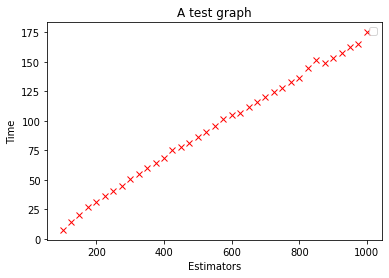

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib
import matplotlib.pyplot as plt

plt.xlabel("Estimators")
plt.ylabel("Time")
plt.title("A test graph")
plt.plot(i_list, time_list, 'rx')
# for j in range(len(new_dataFrame)):
#     plt.plot(i_list[j],time_list[j])
plt.legend()
plt.show()
plt.savefig('/content/TM_E1000.png')

No handles with labels found to put in legend.


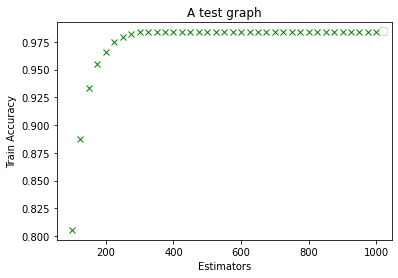

<Figure size 432x288 with 0 Axes>

In [44]:
plt.xlabel("Estimators")
plt.ylabel("Train Accuracy")
plt.title("A test graph")
plt.plot(i_list, train_score_list, 'gx')
# for j in range(len(new_dataFrame)):
#     plt.plot(i_list[j],train_score_list[j])
plt.legend()
plt.show()
plt.savefig('/content/TRN_A1000.png')

No handles with labels found to put in legend.


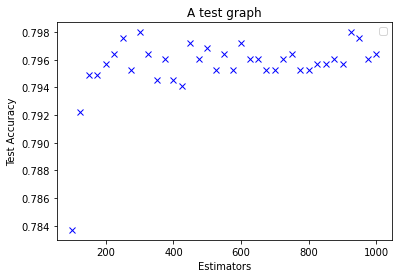

<Figure size 432x288 with 0 Axes>

In [45]:
plt.xlabel("Estimators")
plt.ylabel("Test Accuracy")
plt.title("A test graph")
plt.plot(i_list, test_score_list, 'bx')
# for j in range(len(new_dataFrame)):
#     plt.plot(i_list[j],test_score_list[j])
plt.legend()
plt.show()
plt.savefig('/content/TST_A1000.png')